# Crime victims forecasting
## In this notebook we will implement a simple algorithm to forecast how crime victims trends would have been if covid had not existed.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import requests
import itertools
import statsmodels.api as sm
from pylab import rcParams
from fbprophet import Prophet

## Let's start working with crime victims reports

In [3]:
victim_crimes_df = pd.read_csv("Databases/IDVFC_NM_oct2020 - IDVFC_NM_oct2020.csv")
#Rename months so we can sort them properly
victim_crimes_df.columns

Index(['Año', 'Clave_Ent', 'Entidad', 'Bien jurídico afectado',
       'Tipo de delito', 'Subtipo de delito', 'Modalidad', 'Sexo',
       'Rango de edad', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'],
      dtype='object')

In [4]:
victim_crimes_df.columns = ['Año', 'Clave_Ent', 'Entidad', 'Bien jurídico afectado',
       'Tipo de delito', 'Subtipo de delito', 'Modalidad', 'Sexo',
       'Rango de edad', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [5]:
victim_crimes_df = victim_crimes_df.set_index(['Año', 'Clave_Ent', 'Entidad', 'Bien jurídico afectado',
       'Tipo de delito', 'Subtipo de delito', 'Modalidad', 'Sexo',
       'Rango de edad']).stack().reset_index().rename(columns={'level_9': 'Mes', 0: 'No. de victimas'})

In [6]:
victim_crimes_df.head()

,Año,Clave_Ent,Entidad,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Sexo,Rango de edad,Mes,No. de victimas
0,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,Mujer,Menores de edad (0-17),1,0.0
1,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,Mujer,Menores de edad (0-17),2,0.0
2,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,Mujer,Menores de edad (0-17),3,0.0
3,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,Mujer,Menores de edad (0-17),4,0.0
4,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,Mujer,Menores de edad (0-17),5,0.0


In [7]:
victim_crimes_df['Tipo de delito'].unique()

array(['Homicidio', 'Lesiones', 'Feminicidio',
       'Otros delitos que atentan contra la vida y la integridad corporal',
       'Secuestro', 'Tráfico de menores', 'Rapto',
       'Otros delitos que atentan contra la libertad personal',
       'Extorsión', 'Corrupción de menores', 'Trata de personas',
       'Otros delitos contra la sociedad', 'Aborto'], dtype=object)

In [8]:
victim_crimes_df['Subtipo de delito'].unique()

array(['Homicidio doloso', 'Homicidio culposo', 'Lesiones dolosas',
       'Lesiones culposas', 'Feminicidio',
       'Otros delitos que atentan contra la vida y la integridad corporal',
       'Secuestro', 'Tráfico de menores', 'Rapto',
       'Otros delitos que atentan contra la libertad personal',
       'Extorsión', 'Corrupción de menores', 'Trata de personas',
       'Otros delitos contra la sociedad', 'Aborto'], dtype=object)

## Como primera prueba realicemos el analisis a nivel nacional

In [9]:
national_victims_df = victim_crimes_df[['Año', 'Mes', 'No. de victimas']].groupby(['Año', 'Mes']).sum().reset_index()

national_victims_df['DateTime'] = national_victims_df.apply(lambda entry: pd.to_datetime(
    pd.Timestamp(year = int(entry['Año']), month = int(entry['Mes']),
                 day = 1)), axis=1)

national_victims_df.drop(columns = ['Año', 'Mes'], inplace=True)

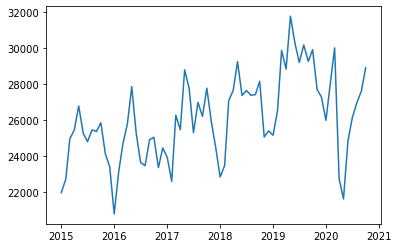

In [10]:
plt.plot(national_victims_df.set_index('DateTime'))

## We need to split the dataframe in the data before and after COVID19
The pandemic started in mexico in march

In [11]:
national_victims_before_covid_df = national_victims_df.where(national_victims_df['DateTime'] < pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')
national_victims_after_covid_df = national_victims_df.where(national_victims_df['DateTime'] > pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

In [12]:
national_victims_after_covid_df.index

DatetimeIndex(['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', name='DateTime', freq=None)

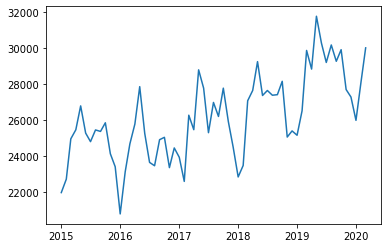

In [13]:
plt.plot(national_victims_before_covid_df)

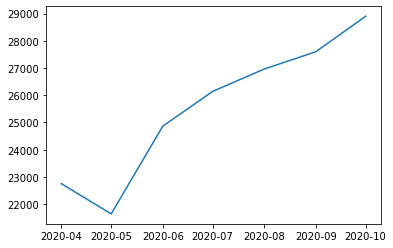

In [14]:
plt.plot(national_victims_after_covid_df)

Let's see the decomposition of the national crimes taking covid into consideration.

There is a clear decline in the trend, this means that the pandemic had a strong impact in diminishing the total amount of crimes. 

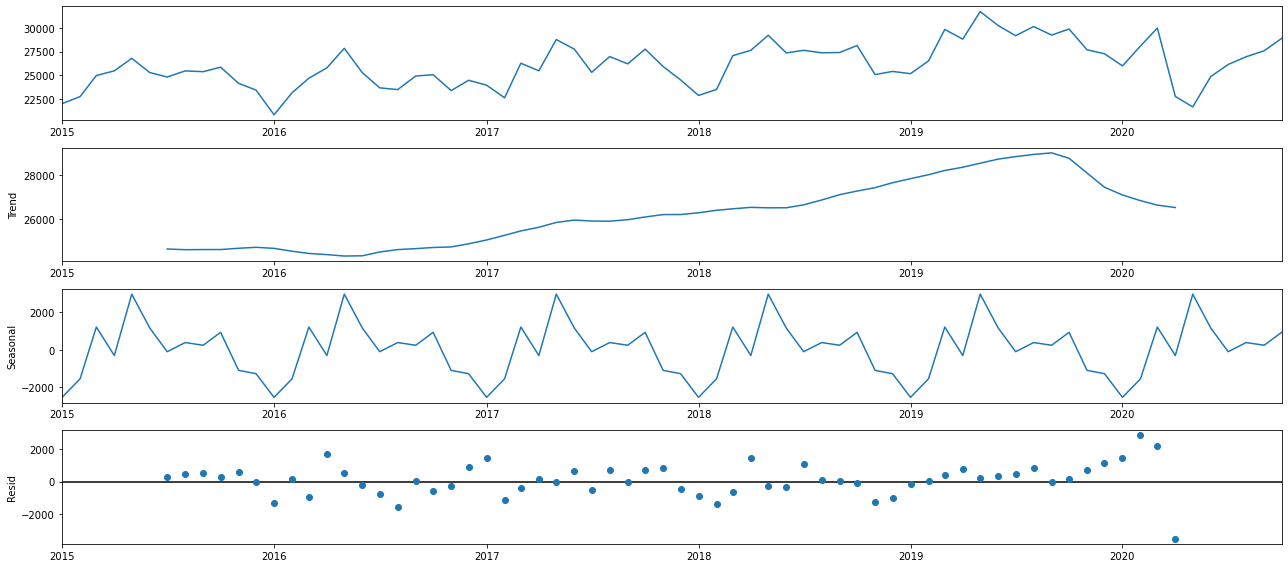

In [15]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_victims_df.set_index('DateTime'), model='additive')
fig = decomposition.plot()
plt.show()

If we take into account only the crimes before covid, the trend is positive and considerably constant. We will make use of this data to predict how the trend would have been if the pandemic had not ocurred.

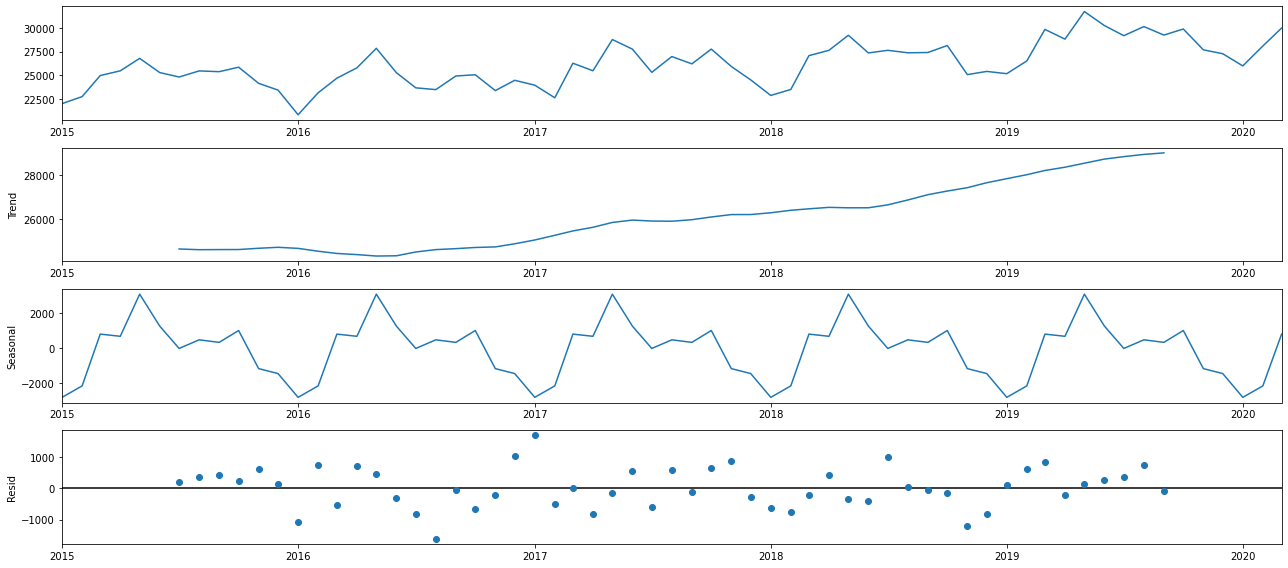

In [16]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_victims_before_covid_df, model='additive')
fig = decomposition.plot()
plt.show()

## Let's use ARIMA as the time series forecaster

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [18]:
params_values = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(national_victims_before_covid_df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False);
            results = mod.fit()
            params_values.append([param, param_seasonal, results.aic])
        except:
            continue

/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMT

In [19]:
pd.DataFrame(params_values).sort_values(2)

,0,1,2
27,"(0, 1, 1)","(0, 1, 1, 12)",597.618398
31,"(0, 1, 1)","(1, 1, 1, 12)",598.493530
59,"(1, 1, 1)","(0, 1, 1, 12)",599.616839
63,"(1, 1, 1)","(1, 1, 1, 12)",600.736835
62,"(1, 1, 1)","(1, 1, 0, 12)",615.003751
...,...,...,...
32,"(1, 0, 0)","(0, 0, 0, 12)",1099.114643
1,"(0, 0, 0)","(0, 0, 1, 12)",1166.685828
8,"(0, 0, 1)","(0, 0, 0, 12)",1375.612902
0,"(0, 0, 0)","(0, 0, 0, 12)",1440.129680


In [20]:
mod = sm.tsa.statespace.SARIMAX(national_victims_before_covid_df,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8180      0.132     -6.193      0.000      -1.077      -0.559
ar.S.L12      -0.1445      0.073     -1.987      0.047      -0.287      -0.002
ma.S.L12      -0.4988      0.146     -3.418      0.001      -0.785      -0.213
sigma2      7.097e+05    2.1e+05      3.386      0.001    2.99e+05    1.12e+06


/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


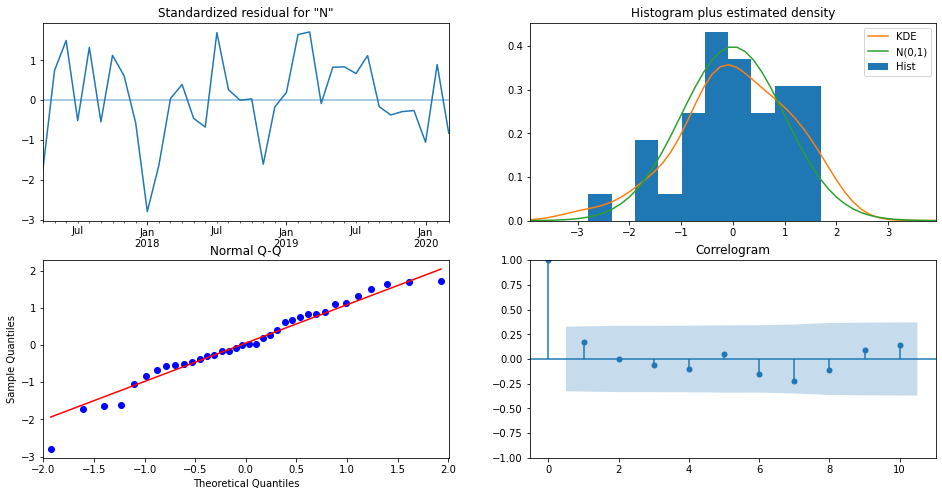

In [21]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [22]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-01'), end=pd.to_datetime('2020-10-01'), dynamic=False)
pred_ci = pred.conf_int()

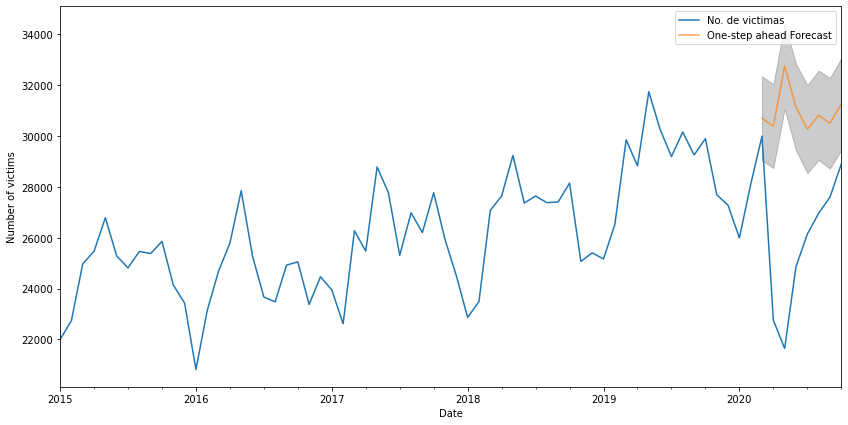

In [23]:
ax = national_victims_df.set_index('DateTime').plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of victims')
plt.legend()
plt.show()

## Let's use FBProphet to predict this data

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


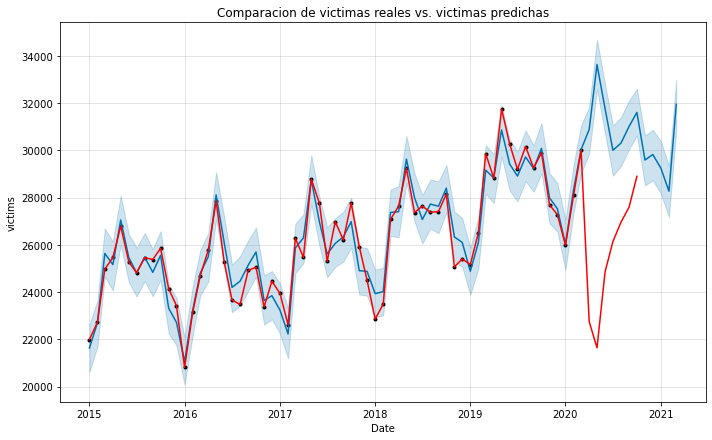

In [24]:
nat_victims_before_cov_df_renamed = national_victims_before_covid_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de victimas': 'y'})
national_victims_model = Prophet(interval_width=0.95)
national_victims_model.fit(nat_victims_before_cov_df_renamed)

national_victims_forecast = national_victims_model.make_future_dataframe(periods=12, freq='MS')
national_victims_forecast = national_victims_model.predict(national_victims_forecast)

national_victims_model.plot(national_victims_forecast, xlabel = 'Date', ylabel = 'victims')
plt.plot(national_victims_df.set_index('DateTime'), color='r')
plt.title('Comparacion de victimas reales vs. victimas predichas');

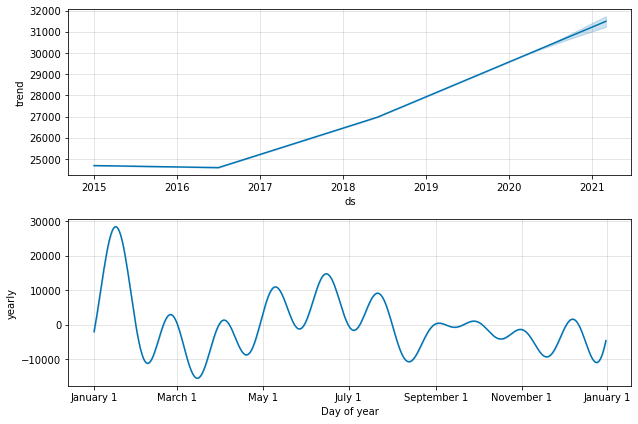

In [25]:
fig2 = national_victims_model.plot_components(national_victims_forecast)

## Let's repeat all over again, but splitting by sex, male vs female

In [26]:
sex_crimes = ['Homicidio doloso', 'Homicidio culposo', 'Lesiones dolosas',
       'Lesiones culposas', 'Feminicidio',
       'Otros delitos que atentan contra la vida y la integridad corporal',
       'Secuestro', 'Tráfico de menores', 'Rapto',
       'Otros delitos que atentan contra la libertad personal',
       'Extorsión', 'Corrupción de menores', 'Trata de personas']

In [29]:
female_victim_crimes_df = victim_crimes_df.where(victim_crimes_df['Sexo'] == 'Mujer').dropna()
female_victim_crimes_df = female_victim_crimes_df.where(female_victim_crimes_df['Subtipo de delito'].isin(sex_crimes)).dropna()
female_victim_crimes_df.head()

,Año,Clave_Ent,Entidad,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Sexo,Rango de edad,Mes,No. de victimas
0,2015.0,1.0,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,Mujer,Menores de edad (0-17),1.0,0.0
1,2015.0,1.0,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,Mujer,Menores de edad (0-17),2.0,0.0
2,2015.0,1.0,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,Mujer,Menores de edad (0-17),3.0,0.0
3,2015.0,1.0,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,Mujer,Menores de edad (0-17),4.0,0.0
4,2015.0,1.0,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,Mujer,Menores de edad (0-17),5.0,0.0


In [30]:
male_victim_crimes_df = victim_crimes_df.where(victim_crimes_df['Sexo'] == 'Hombre').dropna()

In [31]:
national_female_victims_df = female_victim_crimes_df[['Año', 'Mes', 'No. de victimas']].groupby(['Año', 'Mes']).sum().reset_index()

national_female_victims_df['DateTime'] = national_female_victims_df.apply(lambda entry: pd.to_datetime(
    pd.Timestamp(year = int(entry['Año']), month = int(entry['Mes']), 
                 day = 1)), axis=1)

national_female_victims_df.drop(columns = ['Año', 'Mes'], inplace=True)

In [32]:
national_male_victims_df = male_victim_crimes_df[['Año', 'Mes', 'No. de victimas']].groupby(['Año', 'Mes']).sum().reset_index()

national_male_victims_df['DateTime'] = national_male_victims_df.apply(lambda entry: pd.to_datetime(
    pd.Timestamp(year = int(entry['Año']), month = int(entry['Mes']), 
                 day = 1)), axis=1)

national_male_victims_df.drop(columns = ['Año', 'Mes'], inplace=True)

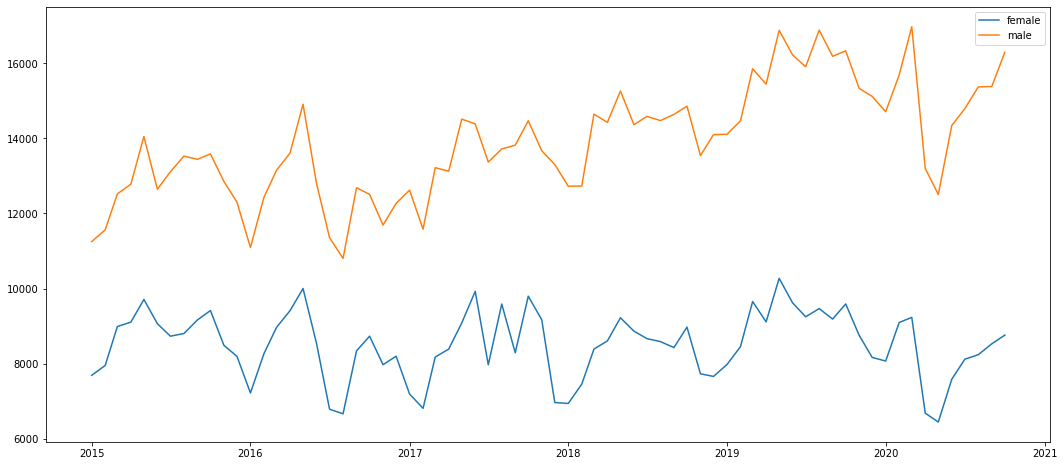

In [33]:
plt.plot(national_female_victims_df.set_index('DateTime'), label='female')
plt.plot(national_male_victims_df.set_index('DateTime'), label = 'male')
plt.legend()

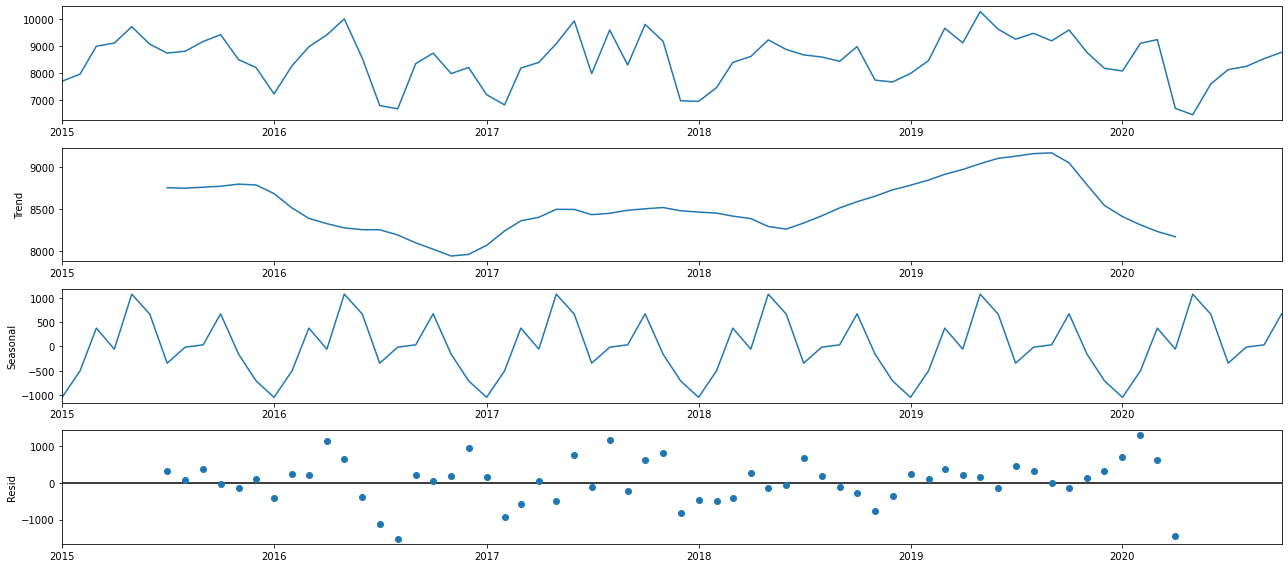

In [34]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_female_victims_df.set_index('DateTime'), model='additive')
fig = decomposition.plot()
plt.show()

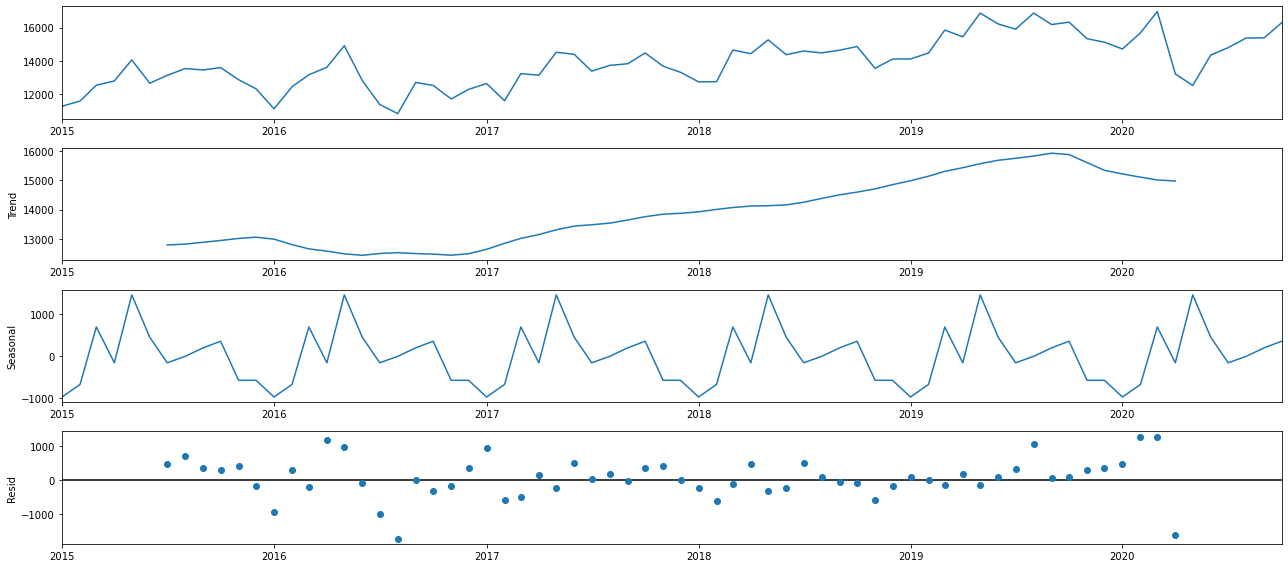

In [38]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_male_victims_df.set_index('DateTime'), model='additive')
fig = decomposition.plot()
plt.show()

## Let's split both dataframes in before and after covid19

In [36]:
national_female_victims_before_covid_df = national_female_victims_df.where(
    national_female_victims_df['DateTime'] < pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

national_female_victims_after_covid_df = national_female_victims_df.where(
    national_female_victims_df['DateTime'] > pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

In [37]:
national_male_victims_before_covid_df = national_male_victims_df.where(
    national_male_victims_df['DateTime'] < pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

national_male_victims_after_covid_df = national_male_victims_df.where(
    national_male_victims_df['DateTime'] > pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


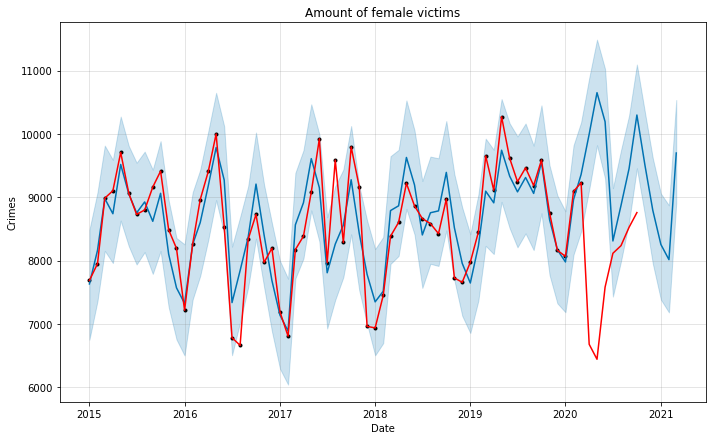

In [45]:
nat_female_victims_before_cov_df_renamed = national_female_victims_before_covid_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de victimas': 'y'})
national_female_model = Prophet(interval_width=0.95)
national_female_model.fit(nat_female_victims_before_cov_df_renamed)

national_female_forecast = national_female_model.make_future_dataframe(periods=12, freq='MS')
national_female_forecast = national_female_model.predict(national_female_forecast)

fig1 = national_female_model.plot(national_female_forecast, xlabel = 'Date', ylabel = 'Crimes')
plt.plot(national_female_victims_df.set_index('DateTime'), color='r', label = 'Real data')
plt.title('Amount of female victims')
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


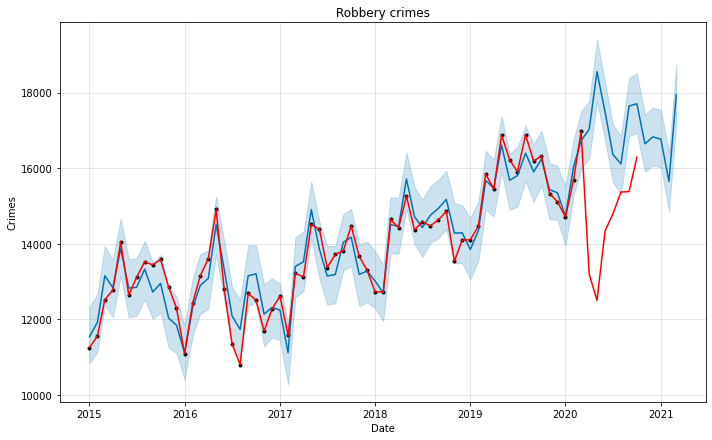

In [46]:
nat_male_before_cov_df_renamed = national_male_victims_before_covid_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de victimas': 'y'})
national_male_model = Prophet(interval_width=0.95)
national_male_model.fit(nat_male_before_cov_df_renamed)

national_male_forecast = national_male_model.make_future_dataframe(periods=12, freq='MS')
national_male_forecast = national_male_model.predict(national_male_forecast)

national_male_model.plot(national_male_forecast, xlabel = 'Date', ylabel = 'Crimes')
plt.plot(national_male_victims_df.set_index('DateTime'), color='r')
plt.title('Robbery crimes');